In [1]:
import ROOT, os, sys, glob
import numpy as np
import math
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed
from array import array

ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.2.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M1p1_filtered_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M1p4_filtered_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr

In [3]:
def Efficiency_plotter(file_name, M):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    #entries_full_indi = rdf.Count().GetValue()
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    #rdf_Gendimu = makeDimuonPairs("Tk",rdf_Tkdimu) 

    
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0.8*M,1.2*M),"TkDiMu_mass")
    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    h_GenDiMu_mass = rdf_genDiMu.Histo1D(("","",50,0.8*M,1.2*M),"GenDiMu_mass")
    
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}Mu_minPT>2.) ")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwQual",f"TkDiMu_hwQual[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwIsoSum",f"TkDiMu_hwIsoSum[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwIsoSumAp",f"TkDiMu_hwIsoSumAp[{name}DiMu_good]")
        #rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    #rdf_selFeat = select_ind("Gen",rdf_idxSel)
    rdf_Tk_selFeat = select_ind("Tk", rdf_genDiMu)
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0.8*M,1.2*M),"TkDiMu_selMass")
    
####################################################################################################################################################################    
   
    rdf_Gen_selFeat = select_ind("Gen", rdf_Tk_selFeat)
    h_GenDiMu_selMass = rdf_Gen_selFeat.Histo1D(("","",50,0.8*M,1.2*M),"GenDiMu_selMass")
    
####################################################################################################################################################################
    def indexSelect(rdf,name):
        rdf = rdf.Define(f"{name}DiMu_indMatch",f"({name}DiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"{name}_IdxDiMu_indices", f"{name}DiMu_indices[{name}DiMu_indMatch]")
        rdf = rdf.Filter(f"Sum({name}DiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_Idx",f"{name}_IdxDiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_IdxMass",f"{name}DiMu_mass[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxCharge",f"{name}DiMu_charge[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_Idxdz",f"{name}DiMu_dz[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxMinPt",f"{name}Mu_minPT[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwIsoSum",f"{name}DiMu_hwIsoSum[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwIsoSumAp",f"{name}DiMu_hwIsoSumAp[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwQual",f"{name}DiMu_hwQual[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxEta",f"{name}DiMu_eta[{name}DiMu_indMatch]")
        return rdf;

    rdf_idxSel_Gen = indexSelect(rdf_Gen_selFeat,"Gen")
    rdf_idxSel_Tk = indexSelect(rdf_idxSel_Gen,"Tk")
    
    entries_idx_pair = rdf_idxSel_Gen.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxGenPairMass = rdf_idxSel_Gen.Histo1D(("Gen_Mass_Idx","Idx m(#mu#mu)_{Gen};m (GeV);Pairs",50,0.8*M,1.2*M), "GenDiMu_IdxMass")

   
    
    
    def select_idx_cut(rdf,name):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_Idx_good", f"({name}DiMu_IdxMinPt > 2.)")                    
        rdf = rdf.Define(f"{name}DiMu_sel_Idx_indices", f"{name}_IdxDiMu_indices[{name}DiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_IdxSel",f"{name}DiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_IdxselMass",f"{name}DiMu_IdxMass[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselCharge",f"{name}DiMu_IdxCharge[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_Idxseldz",f"{name}DiMu_Idxdz[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselMinPt",f"{name}DiMu_IdxMinPt[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselEta",f"{name}DiMu_IdxEta[{name}DiMu_Idx_good]")
        
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwQual",f"{name}DiMu_IdxhwQual[{name}DiMu_Idx_good]")
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwIsoSum",f"{name}DiMu_IdxhwIsoSum[{name}DiMu_Idx_good")
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwIsoSumAp",f"{name}DiMu_IdxhwIsoSumAp[{name}DiMu_Idx_good]")
        #rdf = rdf.Define(f"Good{name}DiMu_minIdx",f"{name}DiMu_minIdx[{name}DiMu_Idx_good]")

        return rdf;
    rdf_Gen_IdxselFeat = select_idx_cut(rdf_idxSel_Tk,"Gen")
    
    #rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    entries_selIdx_pair = rdf_Gen_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxGenPairMass = rdf_Gen_IdxselFeat.Histo1D(("Good Gen_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0.8*M,1.2*M), "GenDiMu_IdxselMass")
    
    h1 = h_GenDiMu_selMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = h_GenDiMu_mass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1, h2=h2, h3=h3, e1=e1, e2=e2, entries_idx_pair=entries_idx_pair,entries_gen_pair=entries_gen_pair, entries_no_pair = entries_no_pair, h_GenDiMu_mass=h_GenDiMu_mass, h_GenDiMu_selMass=h_GenDiMu_selMass);

In [4]:
def dY_Number(h, Freq, T, entries):
    h_final = h.Clone()
    h_final.Scale((Freq*T)/entries)
    return h_final;


In [5]:
def signal_strength(Mass, cross_sec, L):
#     #data_bg = {}
    m = float(Mass.replace("p","."))

    
#     #This is for the single neutrino background
#     data_bg_1 = Efficiency_plotter("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root", m)
    
#     h5_bg_1 = dY_Number(data_bg_1['h_GenDiMu_selMass'].GetPtr(), 35*(10**6), 53.5*(10**5), data_bg_1['entries_gen_pair']) #for single neutrino
    
#     k=h5_bg_1.GetXaxis().FindBin(m)
#     N_b_by_m_1=(h5_bg_1.GetBinContent(k)/(h5_bg_1.GetXaxis().GetBinWidth(k)))
    
# ###############################################################################################################################################################    
    
#      #This is for the Drell yan background
#     data_bg_2 = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root", m)
    
#     h5_bg_2 = dY_Number(data_bg_2['h1'], 21.3*(10**6), 400, data_bg_2['entries_gen_pair']) #for single neutrino
    
#     h=h5_bg_2.GetXaxis().FindBin(m)
#     N_b_by_m_2=(h5_bg_2.GetBinContent(h)/(h5_bg_2.GetXaxis().GetBinWidth(h)))
    
# ###############################################################################################################################################################   
    
#     N_b_by_m = N_b_by_m_1 + N_b_by_m_2
    
###############################################################################################################################################################    
    #This is for the signal
    if m <= 4 and m != 3.5:
        file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_filtered_PU200.125X_v0.2.root"    
    else:
        file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_PU200.125X_v0.2.root"
        
    data_sig = Efficiency_plotter(file_name,m)
    h4_sig = data_sig['h1'].Clone()
    #h4_sig.Scale((((cross_sec*(10**3))*(3e-6/(0.02**2)))*L)/data_sig['entries_idx_pair'])
    h4_sig.Scale(1/data_sig['entries_no_pair'])

    #fitting
    h5 = h4_sig.Clone()
    fit = ROOT.TF1("fit", "[0]*exp(-0.5*((x-[1])/[2])^2)", 0.8*m, 1.2*m)
    fit.SetParameter(1, m)
    fit.SetParameter(2, 0.69071)
   
    h5.Fit("fit", "0", "",0.8*m, 1.2*m)
    std = fit.GetParameter(2)
    
    #Calculating N_s
    N_s = h4_sig.Integral(0,h4_sig.GetNbinsX()+1)
    
###############################################################################################################################################################    
    
    #Calculating strength
    #strength = N_s/((N_b_by_m*(2*std))**0.5)
    c = data_sig['entries_no_pair']
    d = data_sig['entries_gen_pair']
    
    
    return dict(h4_sig = h4_sig, std = std, N_s =N_s, c= c, d = d);

    


In [6]:
gr = ROOT.TGraph()

for j,i in enumerate(["10","12","15","25","2","3p5","40","4","5","7"]):
#     [h1,h2,h3],e1,e2=Efficiency_plotter(f"l1MuNano_HAHM_ZdToMuMu_M{i}_PU200.125X_v0.1.root")
#     print(f"for dark photon mass {i} #################################")
#     print(f"Efficiency of the selection for {i} with respect to total unpaired muons is {e1}")
#     print(f"Efficiency of the selection for {i} with respect to paired index matched muons is {e2}")
#     print("")
   
    sens = signal_strength(i, 1, 1)
    m = float(i.replace("p","."))
    #h_add = sens['h4_sig']
    #h_add.SetTitle(f"signal acceptance of dark photon mass = {m}")
    #leg.AddEntry(h_add,f"signal acceptance of dark photon mass = {m}","f")
    #h_add.SetLineColor(colour[j])    
    #hs.Add(h_add)
    n = gr.GetN()
    gr.Set(n+1)
    gr.SetPoint(n, m, sens['N_s'])

 FCN=752.497 FROM MIGRAD    STATUS=CONVERGED     553 CALLS         554 TOTAL
                     EDM=6.53288e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.05994e-01   2.22735e-02   1.14360e-04   1.11508e-03
   2  p1           9.99371e+00   5.17647e-04   4.76537e-06   2.12814e-01
   3  p2          -3.29687e-02   6.41568e-04   3.08059e-06  -3.05275e-01
 FCN=7693.64 FROM MIGRAD    STATUS=CONVERGED     387 CALLS         388 TOTAL
                     EDM=1.61324e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.45170e-03   7.81292e-04   1.70439e-05  -6.41051e-01
   2  p1           1.16272e+01   2.90171e-02   4.20694e-04  -8.19803e-02
   3  p2           2.29776e-01   

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available
Warning in <Fit>: Abnormal termination of minimization.


In [7]:
def Efficiency_plotter_after_sel(file_name, M):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    #rdf_Gendimu = makeDimuonPairs("Tk",rdf_Tkdimu) 

    
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0.8*M,1.2*M),"TkDiMu_mass")
    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    h_GenDiMu_mass = rdf_genDiMu.Histo1D(("","",50,0.8*M,1.2*M),"GenDiMu_mass")
    
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.) && ({name}DiMu_eta <= 2) ")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwQual",f"TkDiMu_hwQual[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwIsoSum",f"TkDiMu_hwIsoSum[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwIsoSumAp",f"TkDiMu_hwIsoSumAp[{name}DiMu_good]")
        #rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    #rdf_selFeat = select_ind("Gen",rdf_idxSel)
    rdf_Tk_selFeat = select_ind("Tk", rdf_genDiMu)
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0.8*M,1.2*M),"TkDiMu_selMass")
    
####################################################################################################################################################################    
   
    rdf_Gen_selFeat = select_ind("Gen", rdf_Tk_selFeat)
    h_GenDiMu_selMass = rdf_Gen_selFeat.Histo1D(("","",50,0.8*M,1.2*M),"GenDiMu_selMass")
    
####################################################################################################################################################################
    def indexSelect(rdf,name):
        rdf = rdf.Define(f"{name}DiMu_indMatch",f"({name}DiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"{name}_IdxDiMu_indices", f"{name}DiMu_indices[{name}DiMu_indMatch]")
        rdf = rdf.Filter(f"Sum({name}DiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_Idx",f"{name}_IdxDiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_IdxMass",f"{name}DiMu_mass[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxCharge",f"{name}DiMu_charge[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_Idxdz",f"{name}DiMu_dz[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxMinPt",f"{name}Mu_minPT[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwIsoSum",f"{name}DiMu_hwIsoSum[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwIsoSumAp",f"{name}DiMu_hwIsoSumAp[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwQual",f"{name}DiMu_hwQual[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxEta",f"{name}DiMu_eta[{name}DiMu_indMatch]")
        return rdf;

    rdf_idxSel_Gen = indexSelect(rdf_Gen_selFeat,"Gen")
    rdf_idxSel_Tk = indexSelect(rdf_idxSel_Gen,"Tk")
    
    entries_idx_pair = rdf_idxSel_Gen.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxGenPairMass = rdf_idxSel_Gen.Histo1D(("Gen_Mass_Idx","Idx m(#mu#mu)_{Gen};m (GeV);Pairs",50,0.8*M,1.2*M), "GenDiMu_IdxMass")

   
    
    
    def select_idx_cut(rdf,name):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_Idx_good", f"({name}DiMu_IdxCharge <0.1 && {name}DiMu_IdxCharge > -0.1) &&({name}DiMu_Idxdz <1 && ({name}DiMu_Idxdz > -1))&&({name}DiMu_IdxMinPt > 2.)&&({name}DiMu_IdxEta <= 2)")                    
        rdf = rdf.Define(f"{name}DiMu_sel_Idx_indices", f"{name}_IdxDiMu_indices[{name}DiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_IdxSel",f"{name}DiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_IdxselMass",f"{name}DiMu_IdxMass[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselCharge",f"{name}DiMu_IdxCharge[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_Idxseldz",f"{name}DiMu_Idxdz[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselMinPt",f"{name}DiMu_IdxMinPt[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselEta",f"{name}DiMu_IdxEta[{name}DiMu_Idx_good]")
        
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwQual",f"{name}DiMu_IdxhwQual[{name}DiMu_Idx_good]")
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwIsoSum",f"{name}DiMu_IdxhwIsoSum[{name}DiMu_Idx_good")
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwIsoSumAp",f"{name}DiMu_IdxhwIsoSumAp[{name}DiMu_Idx_good]")
        #rdf = rdf.Define(f"Good{name}DiMu_minIdx",f"{name}DiMu_minIdx[{name}DiMu_Idx_good]")

        return rdf;
    rdf_Gen_IdxselFeat = select_idx_cut(rdf_idxSel_Tk,"Gen")
    
    #rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    entries_selIdx_pair = rdf_Gen_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxGenPairMass = rdf_Gen_IdxselFeat.Histo1D(("Good Gen_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0.8*M,1.2*M), "GenDiMu_IdxselMass")
    
    h1 = hGoodIdxGenPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxGenPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1, h2=h2, h3=h3, e1=e1, e2=e2, entries_idx_pair=entries_idx_pair,entries_gen_pair=entries_gen_pair, entries_no_pair = entries_no_pair, h_GenDiMu_mass=h_GenDiMu_mass, h_GenDiMu_selMass=h_GenDiMu_selMass);

In [8]:
def signal_strength_sel(Mass, cross_sec, L):
#     #data_bg = {}
    m = float(Mass.replace("p","."))

    
#     #This is for the single neutrino background
#     data_bg_1 = Efficiency_plotter("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root", m)
    
#     h5_bg_1 = dY_Number(data_bg_1['h_GenDiMu_selMass'].GetPtr(), 35*(10**6), 53.5*(10**5), data_bg_1['entries_gen_pair']) #for single neutrino
    
#     k=h5_bg_1.GetXaxis().FindBin(m)
#     N_b_by_m_1=(h5_bg_1.GetBinContent(k)/(h5_bg_1.GetXaxis().GetBinWidth(k)))
    
# ###############################################################################################################################################################    
    
#      #This is for the Drell yan background
#     data_bg_2 = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root", m)
    
#     h5_bg_2 = dY_Number(data_bg_2['h1'], 21.3*(10**6), 400, data_bg_2['entries_gen_pair']) #for single neutrino
    
#     h=h5_bg_2.GetXaxis().FindBin(m)
#     N_b_by_m_2=(h5_bg_2.GetBinContent(h)/(h5_bg_2.GetXaxis().GetBinWidth(h)))
    
# ###############################################################################################################################################################   
    
#     N_b_by_m = N_b_by_m_1 + N_b_by_m_2
    
###############################################################################################################################################################    
    #This is for the signal
   
    if m <= 4 and m != 3.5:
        file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_filtered_PU200.125X_v0.2.root"    
    else:
        file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_PU200.125X_v0.2.root"
                
    data_sig = Efficiency_plotter_after_sel(file_name,m)
    
    h4_sig = data_sig['h1'].Clone()
    #h4_sig.Scale((((cross_sec*(10**3))*(3e-6/(0.02**2)))*L)/data_sig['entries_idx_pair'])
    h4_sig.Scale(1/data_sig['entries_no_pair'])

    #fitting
    h5 = h4_sig.Clone()
    fit = ROOT.TF1("fit", "[0]*exp(-0.5*((x-[1])/[2])^2)", 0.8*m, 1.2*m)
    fit.SetParameter(1, m)
    fit.SetParameter(2, 0.69071)
   
    h5.Fit("fit", "0", "",0.8*m, 1.2*m)
    std = fit.GetParameter(2)
    
    #Calculating N_s
    N_s = h4_sig.Integral(0,h4_sig.GetNbinsX()+1)
    
###############################################################################################################################################################    
    
    #Calculating strength
    #strength = N_s/((N_b_by_m*(2*std))**0.5)
    c = data_sig['entries_no_pair']
    d = data_sig['entries_gen_pair']
    
    
    return dict(h4_sig = h4_sig, std = std, N_s = N_s, c= c, d = d);

    


In [9]:
def Efficiency_plotter_after_sel_new(file_name, M):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    #rdf_Gendimu = makeDimuonPairs("Tk",rdf_Tkdimu) 

    
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0.8*M,1.2*M),"TkDiMu_mass")
    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    h_GenDiMu_mass = rdf_genDiMu.Histo1D(("","",50,0.8*M,1.2*M),"GenDiMu_mass")
    
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>0.25*{name}DiMu_mass) && ({name}DiMu_eta <= 2) ")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwQual",f"TkDiMu_hwQual[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwIsoSum",f"TkDiMu_hwIsoSum[{name}DiMu_good]")
#         rdf = rdf.Define(f"GoodTkDiMu_hwIsoSumAp",f"TkDiMu_hwIsoSumAp[{name}DiMu_good]")
        #rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    #rdf_selFeat = select_ind("Gen",rdf_idxSel)
    rdf_Tk_selFeat = select_ind("Tk", rdf_genDiMu)
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0.8*M,1.2*M),"TkDiMu_selMass")
    
####################################################################################################################################################################    
   
    rdf_Gen_selFeat = select_ind("Gen", rdf_Tk_selFeat)
    h_GenDiMu_selMass = rdf_Gen_selFeat.Histo1D(("","",50,0.8*M,1.2*M),"GenDiMu_selMass")
    
####################################################################################################################################################################
    def indexSelect(rdf,name):
        rdf = rdf.Define(f"{name}DiMu_indMatch",f"({name}DiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"{name}_IdxDiMu_indices", f"{name}DiMu_indices[{name}DiMu_indMatch]")
        rdf = rdf.Filter(f"Sum({name}DiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_Idx",f"{name}_IdxDiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_IdxMass",f"{name}DiMu_mass[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxCharge",f"{name}DiMu_charge[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_Idxdz",f"{name}DiMu_dz[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxMinPt",f"{name}Mu_minPT[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwIsoSum",f"{name}DiMu_hwIsoSum[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwIsoSumAp",f"{name}DiMu_hwIsoSumAp[{name}DiMu_indMatch]")
#         rdf = rdf.Define(f"{name}DiMu_IdxhwQual",f"{name}DiMu_hwQual[{name}DiMu_indMatch]")
        rdf = rdf.Define(f"{name}DiMu_IdxEta",f"{name}DiMu_eta[{name}DiMu_indMatch]")
        return rdf;

    rdf_idxSel_Gen = indexSelect(rdf_Gen_selFeat,"Gen")
    rdf_idxSel_Tk = indexSelect(rdf_idxSel_Gen,"Tk")
    
    entries_idx_pair = rdf_idxSel_Gen.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxGenPairMass = rdf_idxSel_Gen.Histo1D(("Gen_Mass_Idx","Idx m(#mu#mu)_{Gen};m (GeV);Pairs",50,0.8*M,1.2*M), "GenDiMu_IdxMass")

   
    
    
    def select_idx_cut(rdf,name):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_Idx_good", f"({name}DiMu_IdxCharge <0.1 && {name}DiMu_IdxCharge > -0.1) &&({name}DiMu_Idxdz <1 && ({name}DiMu_Idxdz > -1))&&({name}DiMu_IdxMinPt > 0.25*{name}DiMu_IdxMass)&&({name}DiMu_IdxEta <= 2)")                    
        rdf = rdf.Define(f"{name}DiMu_sel_Idx_indices", f"{name}_IdxDiMu_indices[{name}DiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_IdxSel",f"{name}DiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_IdxselMass",f"{name}DiMu_IdxMass[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselCharge",f"{name}DiMu_IdxCharge[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_Idxseldz",f"{name}DiMu_Idxdz[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselMinPt",f"{name}DiMu_IdxMinPt[{name}DiMu_Idx_good]")
        rdf = rdf.Define(f"{name}DiMu_IdxselEta",f"{name}DiMu_IdxEta[{name}DiMu_Idx_good]")
        
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwQual",f"{name}DiMu_IdxhwQual[{name}DiMu_Idx_good]")
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwIsoSum",f"{name}DiMu_IdxhwIsoSum[{name}DiMu_Idx_good")
#         rdf = rdf.Define(f"{name}DiMu_IdxselhwIsoSumAp",f"{name}DiMu_IdxhwIsoSumAp[{name}DiMu_Idx_good]")
        #rdf = rdf.Define(f"Good{name}DiMu_minIdx",f"{name}DiMu_minIdx[{name}DiMu_Idx_good]")

        return rdf;
    rdf_Gen_IdxselFeat = select_idx_cut(rdf_idxSel_Tk,"Gen")
    
    #rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    entries_selIdx_pair = rdf_Gen_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxGenPairMass = rdf_Gen_IdxselFeat.Histo1D(("Good Gen_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0.8*M,1.2*M), "GenDiMu_IdxselMass")
    
    h1 = hGoodIdxGenPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxGenPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1, h2=h2, h3=h3, e1=e1, e2=e2, entries_idx_pair=entries_idx_pair,entries_gen_pair=entries_gen_pair, entries_no_pair = entries_no_pair, h_GenDiMu_mass=h_GenDiMu_mass, h_GenDiMu_selMass=h_GenDiMu_selMass);

In [10]:
def signal_strength_sel_new(Mass, cross_sec, L):
#     #data_bg = {}
    m = float(Mass.replace("p","."))

    
#     #This is for the single neutrino background
#     data_bg_1 = Efficiency_plotter("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root", m)
    
#     h5_bg_1 = dY_Number(data_bg_1['h_GenDiMu_selMass'].GetPtr(), 35*(10**6), 53.5*(10**5), data_bg_1['entries_gen_pair']) #for single neutrino
    
#     k=h5_bg_1.GetXaxis().FindBin(m)
#     N_b_by_m_1=(h5_bg_1.GetBinContent(k)/(h5_bg_1.GetXaxis().GetBinWidth(k)))
    
# ###############################################################################################################################################################    
    
#      #This is for the Drell yan background
#     data_bg_2 = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root", m)
    
#     h5_bg_2 = dY_Number(data_bg_2['h1'], 21.3*(10**6), 400, data_bg_2['entries_gen_pair']) #for single neutrino
    
#     h=h5_bg_2.GetXaxis().FindBin(m)
#     N_b_by_m_2=(h5_bg_2.GetBinContent(h)/(h5_bg_2.GetXaxis().GetBinWidth(h)))
    
# ###############################################################################################################################################################   
    
#     N_b_by_m = N_b_by_m_1 + N_b_by_m_2
    
###############################################################################################################################################################    
    #This is for the signal
    if m <= 4 and m != 3.5:
        file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_filtered_PU200.125X_v0.2.root"    
    else:
        file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_PU200.125X_v0.2.root"
                
    data_sig = Efficiency_plotter_after_sel_new(file_name,m)
    
    h4_sig = data_sig['h1'].Clone()
    #h4_sig.Scale((((cross_sec*(10**3))*(3e-6/(0.02**2)))*L)/data_sig['entries_idx_pair'])
    h4_sig.Scale(1/data_sig['entries_no_pair'])

    #fitting
    h5 = h4_sig.Clone()
    fit = ROOT.TF1("fit", "[0]*exp(-0.5*((x-[1])/[2])^2)", 0.8*m, 1.2*m)
    fit.SetParameter(1, m)
    fit.SetParameter(2, 0.69071)
   
    h5.Fit("fit", "0", "",0.8*m, 1.2*m)
    std = fit.GetParameter(2)
    
    #Calculating N_s
    N_s = h4_sig.Integral(0,h4_sig.GetNbinsX()+1)
    
###############################################################################################################################################################    
    
    #Calculating strength
    #strength = N_s/((N_b_by_m*(2*std))**0.5)
    c = data_sig['entries_no_pair']
    d = data_sig['entries_gen_pair']
    
    
    return dict(h4_sig = h4_sig, std = std, N_s = N_s, c= c, d = d);

    


 FCN=161.792 FROM MIGRAD    STATUS=CONVERGED     351 CALLS         352 TOTAL
                     EDM=1.05753e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.98393e-01   5.34845e-03   2.41327e-05  -3.35665e-01
   2  p1           9.98936e+00   8.35355e-04   5.20528e-06   9.77333e-03
   3  p2           4.26695e-02   7.94570e-04   3.58818e-06  -7.39172e-01
 FCN=160.791 FROM MIGRAD    STATUS=CONVERGED     347 CALLS         348 TOTAL
                     EDM=1.36776e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.96329e-01   5.30751e-03   2.39452e-05   4.14263e-03
   2  p1           9.98914e+00   8.39404e-04   5.20927e-06  -1.58837e-02
   3  p2          -4.26489e-02   

Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Info in <TCanvas::Print>: png file all_criteria_vs_mass.png has been created


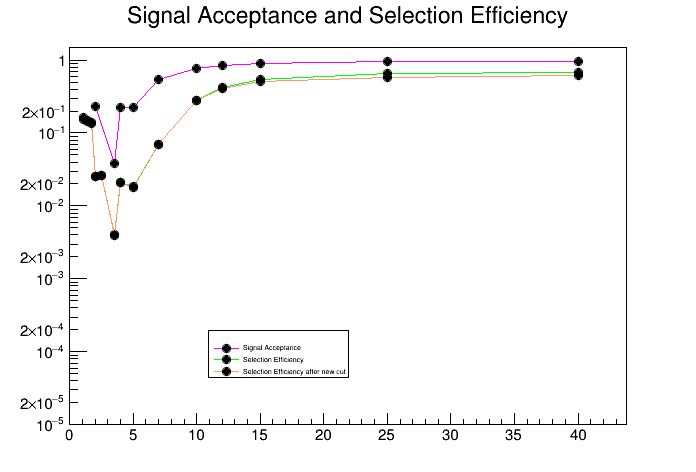

In [11]:
gr_2 = ROOT.TGraph()
gr_new = ROOT.TGraph()
leg = ROOT.TLegend(0.5,0.3,0.3,0.2)
leg.SetHeader("","C")


for j,i in enumerate(["10","15","25","2","5","1p1","1p4","1p7","4","7","12","2p5","3p5","40"]):
#     [h1,h2,h3],e1,e2=Efficiency_plotter(f"l1MuNano_HAHM_ZdToMuMu_M{i}_PU200.125X_v0.1.root")
#     print(f"for dark photon mass {i} #################################")
#     print(f"Efficiency of the selection for {i} with respect to total unpaired muons is {e1}")
#     print(f"Efficiency of the selection for {i} with respect to paired index matched muons is {e2}")
#     print("")
   
    sens_2 = signal_strength_sel(i, 1, 1)
    sens_new = signal_strength_sel_new(i, 1, 1)
    M = float(i.replace("p","."))
    #h_add = sens['h4_sig']
    #h_add.SetTitle(f"selection efficiency of dark photon mass = {m}")
    #h_add.SetLineColor(colour[j])    
    #hs.Add(h_add)
    N = gr_2.GetN()
    K = gr_new.GetN()
    gr_2.Set(N+1)
    gr_new.Set(K+1)
    gr_2.SetPoint(N, M, sens_2['N_s'])
    gr_new.SetPoint(K, M, sens_new['N_s'])

    #gr_std.SetPoint(n,mass,std)
    
    
#c = ROOT.TCanvas("")
#c.cd()
#hs.Draw("hist nostack")
#hs.SetTitle("Selection effieciency (using gen muons) with respect to mass")
#hs.GetXaxis().SetTitle("mass of dark photon(GeV)")
#x.SetTitle("mass of dark photon(GeV)")
#hs.GetYaxis().SetTitle("Selection effieciency (normalised)")
#leg.Draw()
#c.BuildLegend()

#c.Draw()
#c.SaveAs("selection_eff_his_plot.png")
c2 =ROOT.TCanvas()
gr.Sort()
gr_2.Sort()
gr_new.Sort()
#y = gr_2.GetYaxis()
#y.SetTitle("Selection efficency of the signal")
#x = gr.GetXaxis()
#x.SetTitle("Mass of Dark Photon")


# frame = ROOT.TH1F("frame","Signal Acceptance and Selection Efficiency;mass of Dark Photon;log scale",  45, 0., 45.)
# frame.GetYaxis().SetRangeUser(1e-3, 1)
# frame.Draw()
gr.SetTitle("Signal Acceptance and Selection Efficiency")
gr_2.SetTitle("Selection Efficiency")
leg.AddEntry(gr,"Signal Acceptance")
leg.AddEntry(gr_2,"Selection Efficiency")
leg.AddEntry(gr_new,"Selection Efficiency after new cut")
gr.SetLineColor(ROOT.kMagenta)
gr.SetMarkerStyle(20)
gr.GetYaxis().SetRangeUser(1e-5,1.5)
gr.Draw("ALP")
#gr.SetLogy(True)
y = gr.GetYaxis()
y.SetMoreLogLabels()
gr_2.SetLineColor(ROOT.kGreen)
gr_2.SetMarkerStyle(20) 
gr_2.Draw("LP")
gr_new.SetLineColor(ROOT.kOrange+6)
gr_new.SetMarkerStyle(20) 
gr_new.Draw("LP")
c2.SetLogy(True)

leg.Draw()

c2.Draw()    

c2.SaveAs("all_criteria_vs_mass.png")